# Main usage and visualization 
> Runtime: about 2min after loading the dataset.

This notebook is run on the POISED dataset.

In [1]:
import scyan

Global seed set to 0


## Model initialization and fitting

In [2]:
adata, table = scyan.data.load("poised") # Load data (automatic)

In [3]:
# When training for the first time on a new dataset, we advise to start with the default arguments (i.e., remove 'prior_std' and 'lr')
model = scyan.Scyan(adata, table, prior_std=0.25, lr=0.0001)
model.fit()

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/quentinblampey/Library/Caches/pypoetry/virtualenvs/scyan-5lsXrWE1-py3.9/lib/python3.9/site-packages/pytorch_lightning/trainer/setup.py:200: UserWarning: MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.
  rank_zero_warn(

  | Name   | Type        | Params
---------------------------------------
0 | module | ScyanModule | 31.9 K
---------------------------------------
31.9 K    Trainable params
0         Non-trainable params
31.9 K    Total params
0.128     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

Scyan model with N=4178320 cells, P=26 populations and M=19 markers.
   ├── No covariate provided.
   └── Batch correction mode: False

### Run predictions
Predictions are saved in `adata.obs.scyan_pop` by default
> NB: The cells that are unknown are annotated by `np.nan`

In [4]:
model.predict()

# For simplicity, we don't consider 'DC others', and we merge 'cMonocytes CD14mid' into 'cMonocytes'
adata.obs["scyan_pop"] = adata.obs.scyan_pop.replace("DC others", "Unknown").replace("cMonocytes CD14mid", "cMonocytes")

DataLoader:   0%|          | 0/511 [00:00<?, ?it/s]

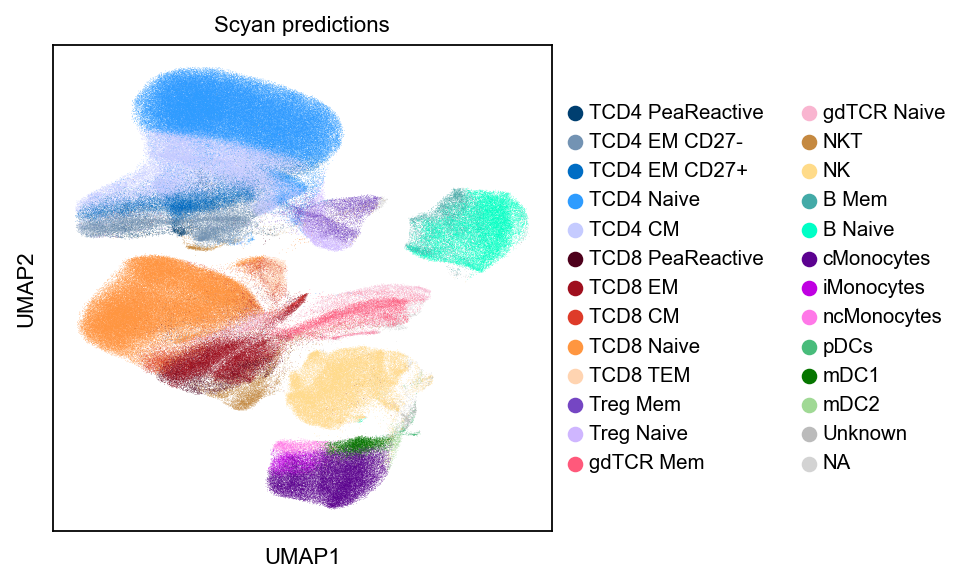

In [5]:
scyan.plot.umap(adata, color="scyan_pop", title="Scyan predictions", palette=adata.uns["palette"])

## Visualization and interpretability

### Latent expressions for all populations

Expressions close to $-1$ represent negative expressions, while expressions close to $1$ represent positive expressions. Thus, $0$ can be considered as a mid expression.

DataLoader:   0%|          | 0/25 [00:00<?, ?it/s]

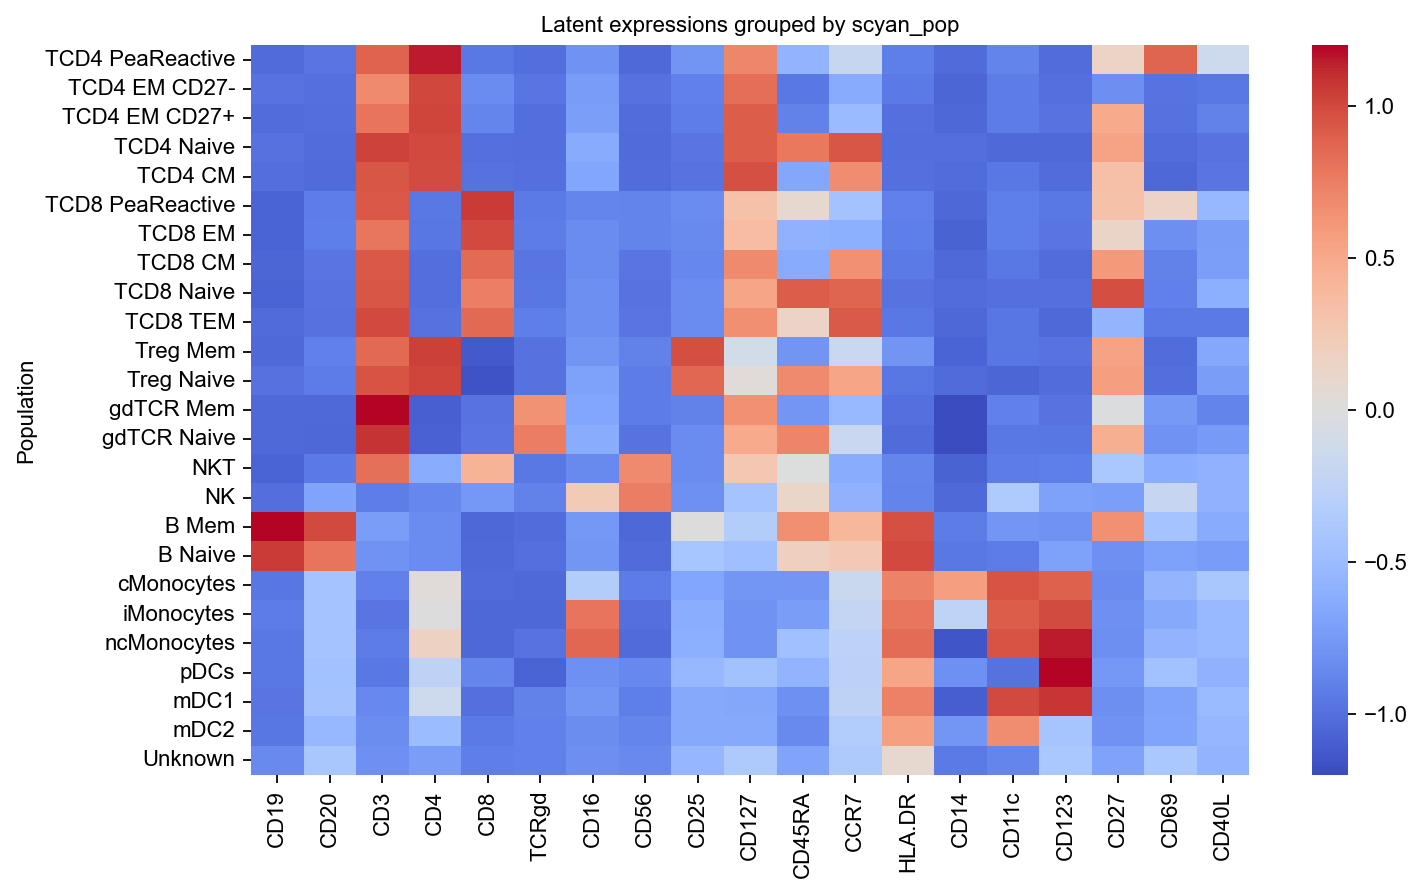

In [6]:
scyan.plot.pops_expressions(model)

### Pairwise scatter plots
The populations below can be shown on 3 scatter plots (the markers are automatically chosen to make the best population separation).

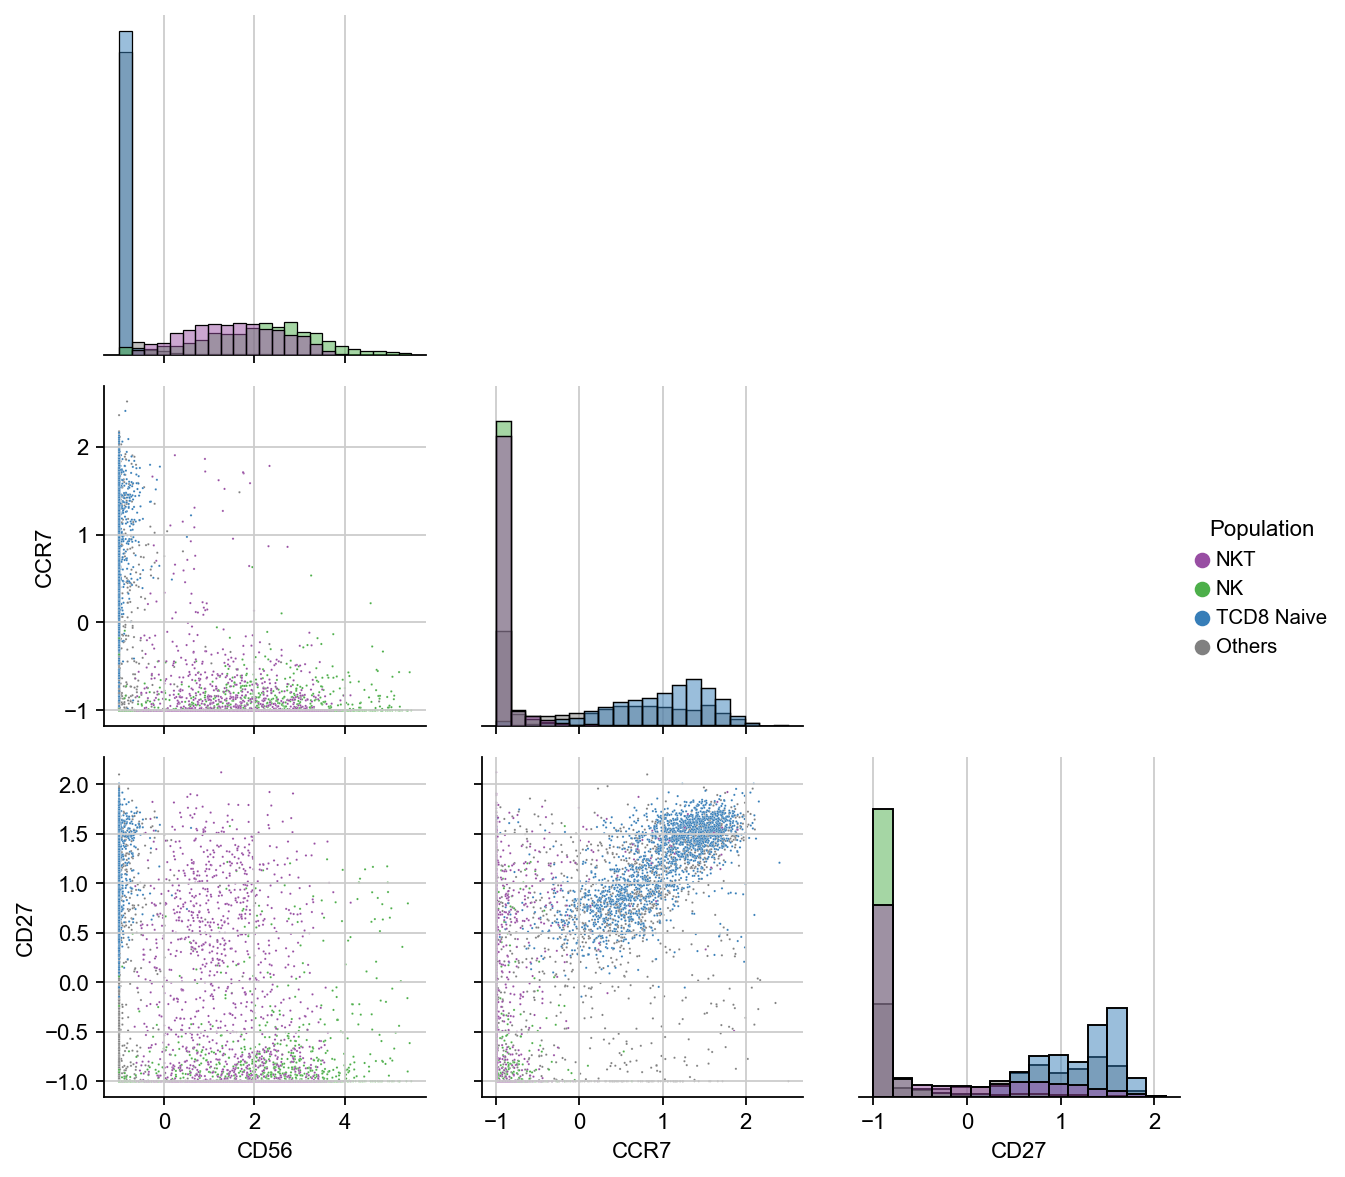

In [7]:
populations = ['NKT', 'NK', 'TCD8 Naive']
scyan.plot.scatter(adata, populations, n_markers=3)

### Model interpretability for one population
Let's now consider one specific population: non-classical monocytes.

In [8]:
population = "ncMonocytes"

DataLoader:   0%|          | 0/3 [00:00<?, ?it/s]

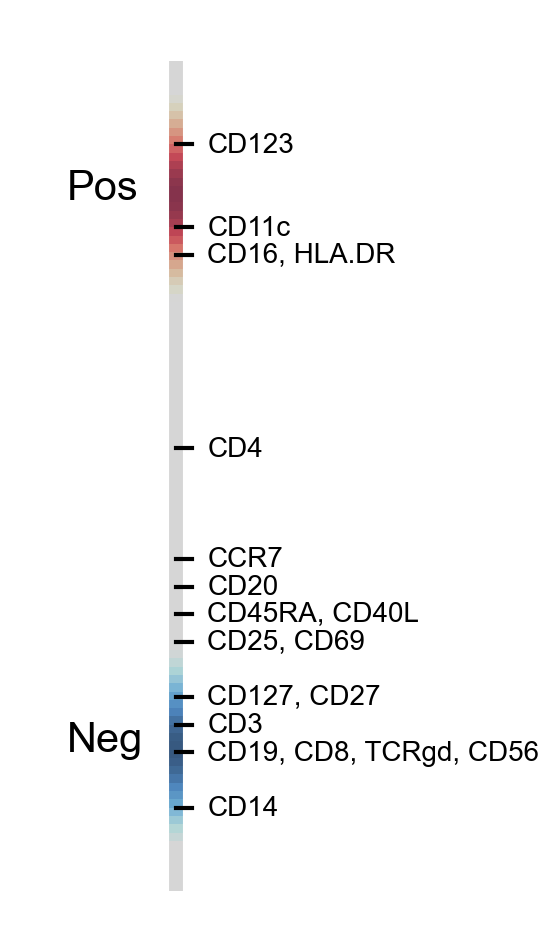

In [9]:
scyan.plot.pop_expressions(model, population)

Interpret why Scyan predicted ncMonocyte and not another population. Dark values correspond to a marker that reduces the confidence in predicting a population.

E.g., the dark value on (mDC1, CD16) means that the expressions of CD16 of the targeted cells (that is positive, according to the above figure) reduced the model confidence to predict mDC1, which is indeed expected.

DataLoader:   0%|          | 0/3 [00:00<?, ?it/s]

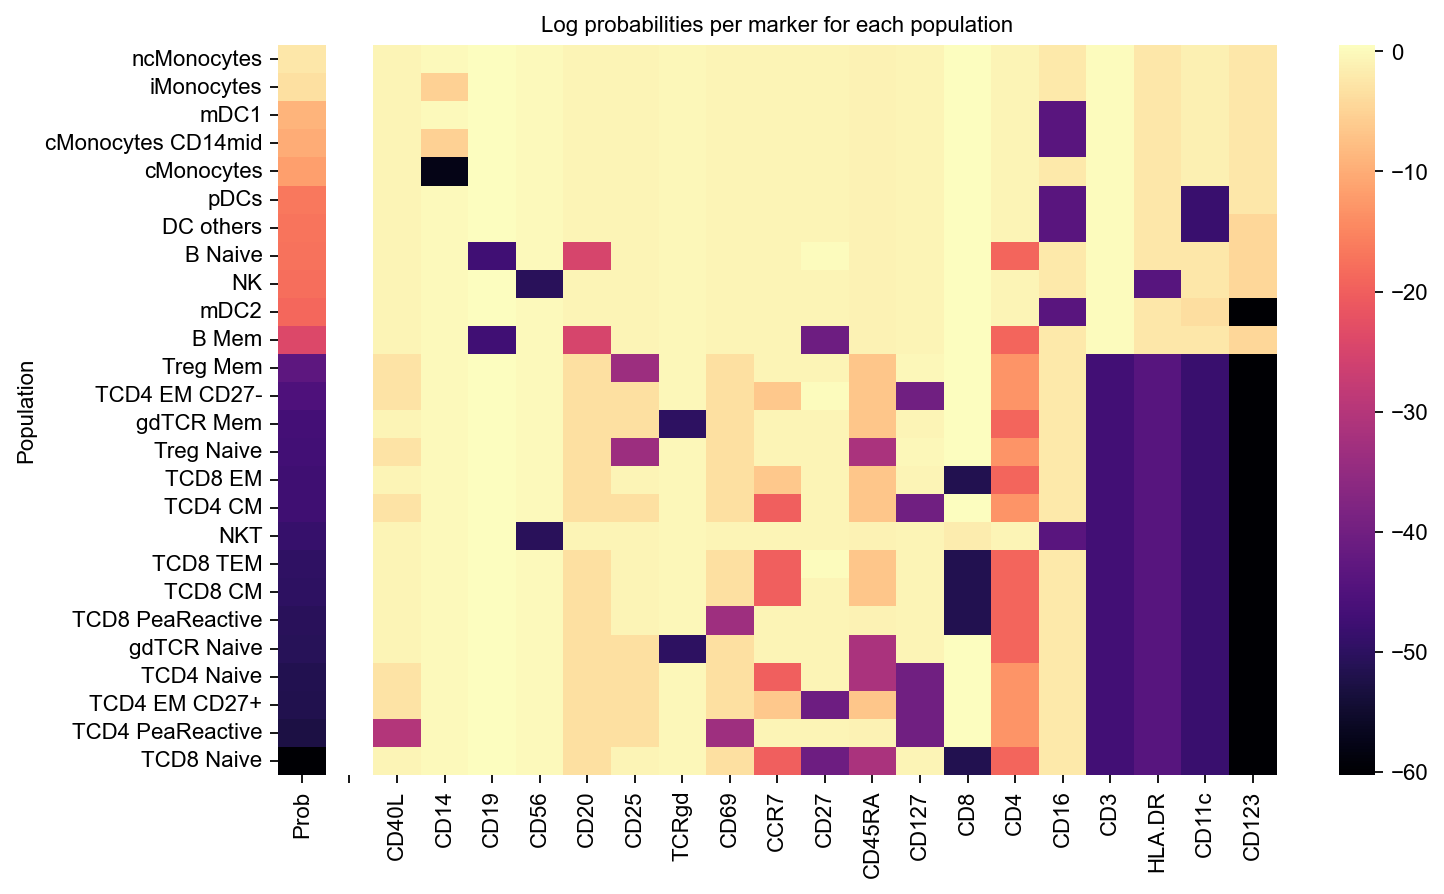

In [10]:
scyan.plot.probs_per_marker(model, population)

## Working with hierarchical populations

For some projects, you may try to annotate many dozens of different populations. It becomes difficult for the human eye to differentiate so many colors on a UMAP. For this reason, you can create multi-level population names (each level going further into the details of the populations), and display only populations at a certain level or go through subpopulations of one specific group of cells.

> NB: you can also try to make groups of colors per main population, as we did with this color palette.

See below an example of hierarchical populations (e.g., both TCD4 PeaReactive and TCD4 EM CD27- are grouped inside one main population called T CD4 cells):

In [40]:
table

,,CD19,CD20,...,CD69,CD40L
Population,level,,,,,
TCD4 PeaReactive,T CD4 cells,-1,-1.0,...,1.0,1.0
TCD4 EM CD27-,T CD4 cells,-1,-1.0,...,-1.0,-1.0
...,...,...,...,...,...,...
mDC2,DCs,-1,NaN,...,NaN,NaN
DC others,DCs,-1,NaN,...,NaN,NaN


Hierarchical population can be described by a tree (if you have not installed pygraphviz yet, run `pip install pygraphviz`).
This is an example with one intermediate level, but you can add more.

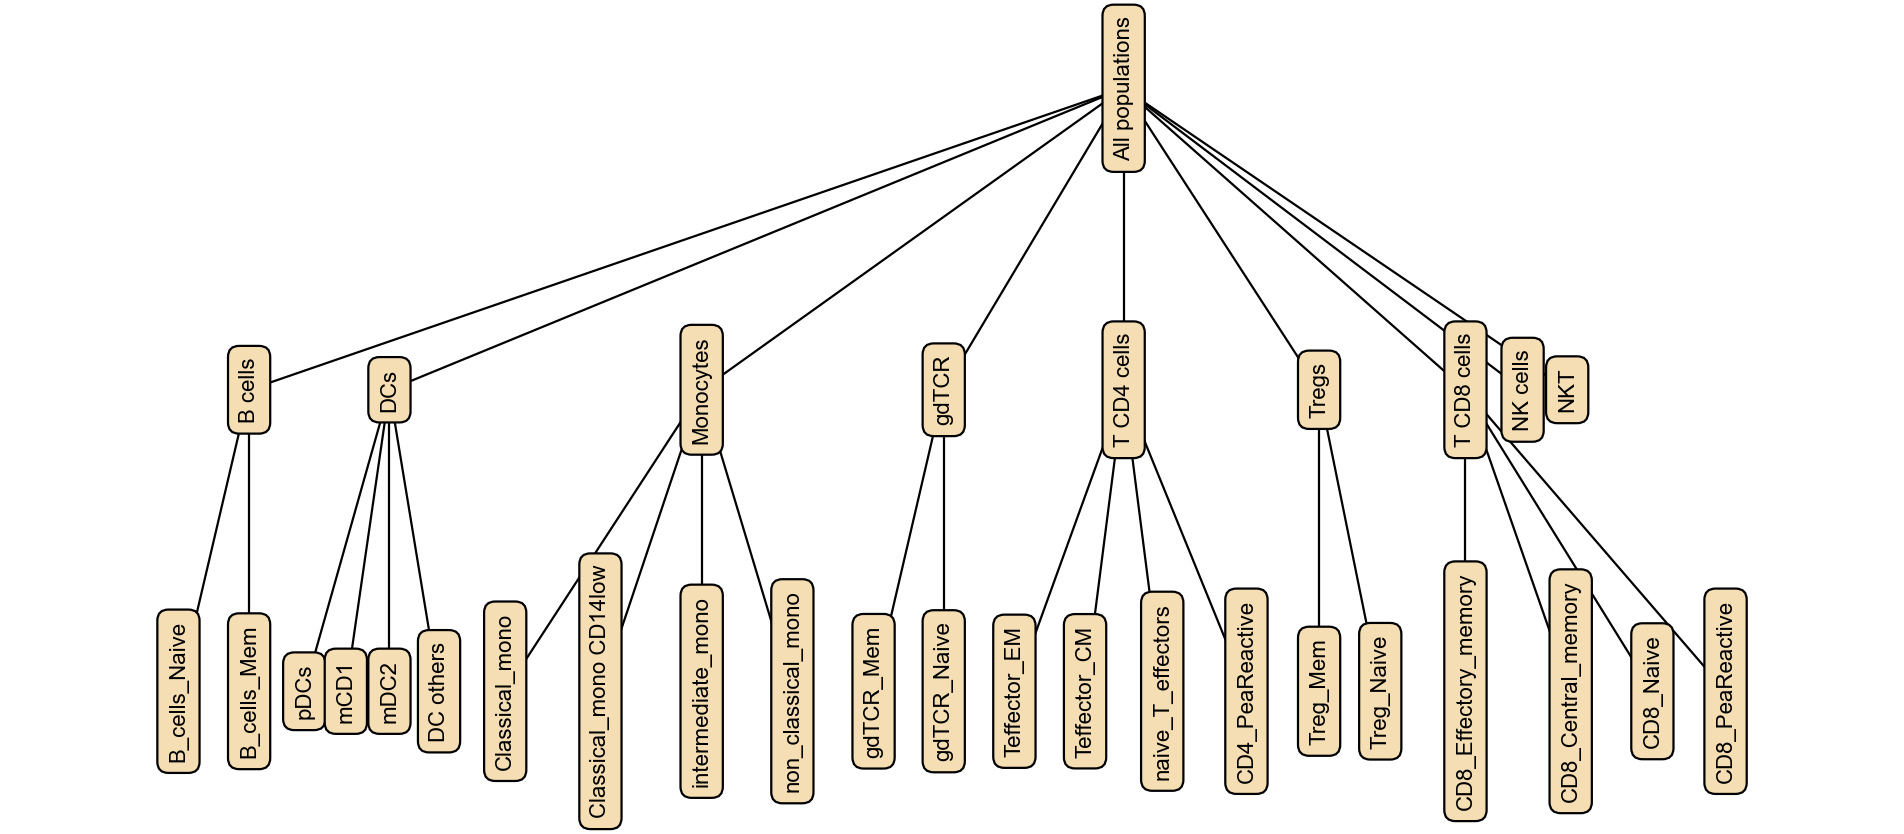

In [5]:
scyan.plot.pops_hierarchy(model, figsize=(15, 6))

### Making a hierarchical table

To create a hierarchical classification of your populations, add (to your knowledge table) one or multiple columns whose names start with `level` (e.g., `level1`, `level_main_population`, or just `level`). We recommend writing these columns after the first column.
The easiest way to create these columns is to manually add them to your knowledge table's `csv` file; see an example [here](https://github.com/MICS-Lab/scyan_data/blob/main/data/aml/groups_demo.csv).

> NB: the first column corresponds to the most detailed population names (i.e. leaves on the tree above), and it contains the population names that Scyan will use for its annotation. The name of this first column should **not** start with `level`, contrary to the columns used to make the population hierarchy.

If you save your data with [`scyan.data.add`](../../api/datasets/#scyan.data.add), you won't need any other formatting because `scyan` will detect the levels using their names and return a multi-index dataframe as displayed above. But if you want to read the table directly, you can read it as a multi-index DataFrame with the following command line:

In [ ]:
import pandas as pd

In [ ]:
pd.read_csv(<table-path.csv>, index_col=[0, 1]) # if you have one population and one level column
pd.read_csv(<table-path.csv>, index_col=[0, 1, 2]) # if you have two levels

### Plot the different population levels on a UMAP

You can use the key associated with a specific level to display all populations at this level.

E.g., if you want to display the level called `level2`, use `color="scyan_pop_level2"`.

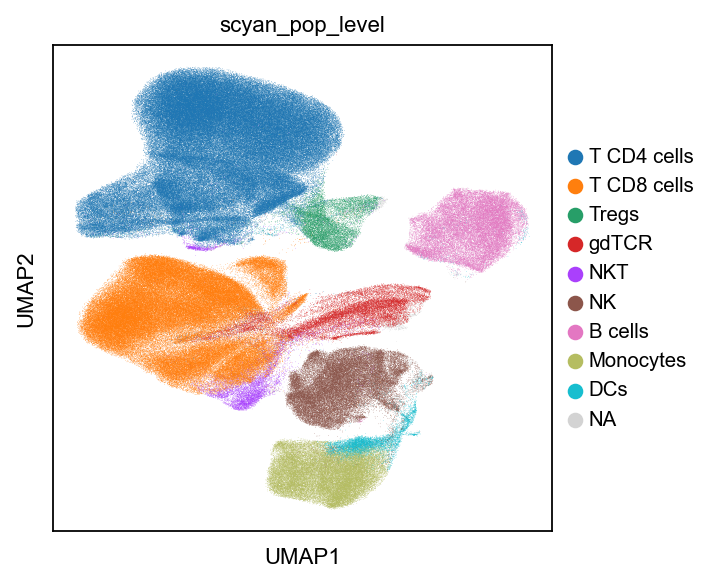

In [6]:
scyan.plot.umap(adata, color="scyan_pop_level")

You can also use [`scyan.plot.pop_level`](../../api/plots/#scyan.plot.pop_level) to display subpopulations from one group at this level. By default, it uses `level='level'`, but you can change it.

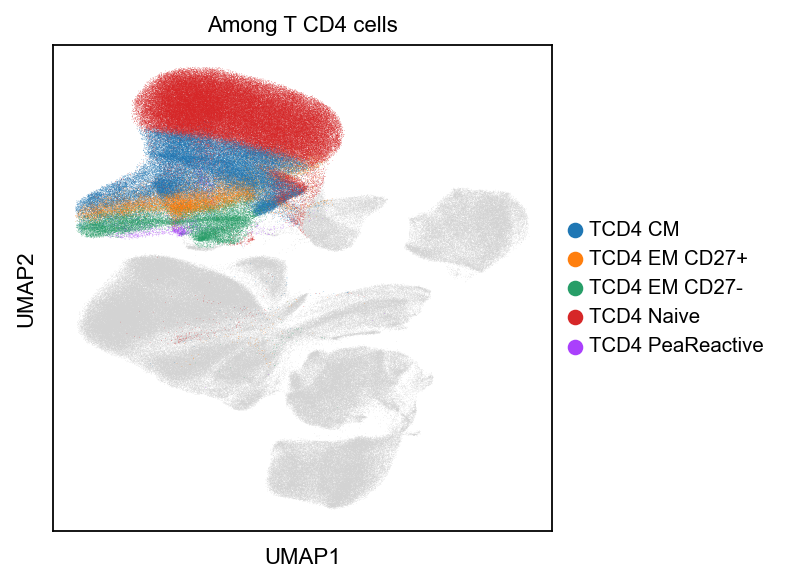

In [7]:
scyan.plot.pop_level(model, "T CD4 cells") # Plot all populations that belongs to the group "T CD4 cells"

### Making a block color palette
The population tree can be used to defined colors by block, i.e. similar colors for populations of the same groups. For instance, here, all five subpopulations of T CD4 cells are in shades of green.

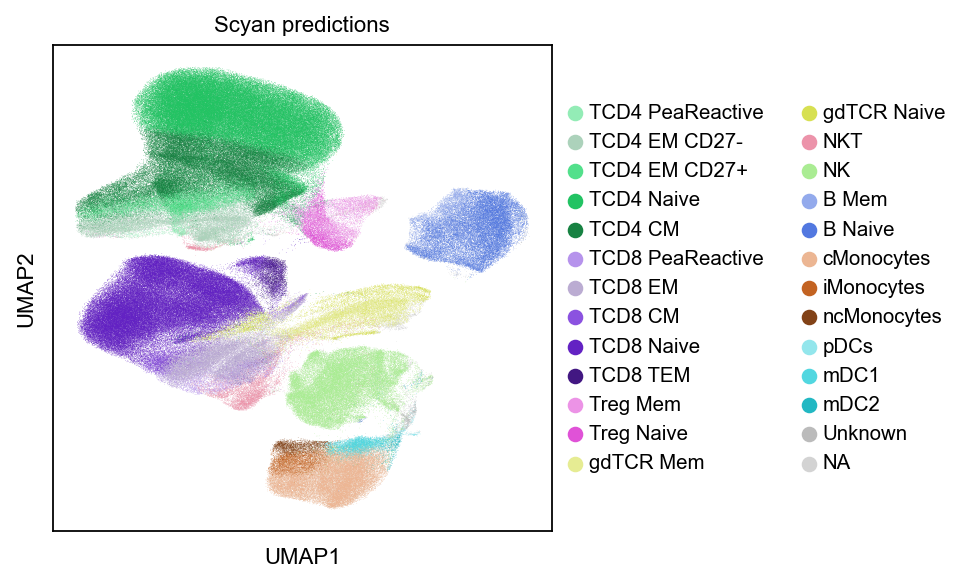

In [9]:
palette = scyan.tools.palette_level(table)
palette["Unknown"] = "#bbb" # Only if you renamed the np.nan cells as "Unknown"

scyan.plot.umap(adata, color="scyan_pop", title="Scyan predictions", palette=palette)

### Compatibility with the other tools/plots

Most plots and tools can also be used on a specific level. Actually, when making prediction, scyan also added keys in your `adata.obs` corresponding to each level. Thus, when available, provide `key="scyan_pop_<level>"` to any plot or tool to work at this specific level (where `<level>` is one of `model.level_names`).

Note also that [`model.pops(...)`](../../api/model/#scyan.model.Scyan.pops) can help you navigating through the different populations at different levels of the tree.

In [10]:
print("Available level names:", model.level_names)
print("Populations at level 'level':", model.pops('level'))
print("Children populations of T CD4 cells:", model.pops(children_of='T CD4 cells'))
print("Parent population of B naive cells:", model.pops(parent_of="B Naive"))

Available level names: ['level']
Populations at level 'level': ['T CD8 cells', 'T CD4 cells', 'Monocytes', 'NK', 'DCs', 'Tregs', 'gdTCR', 'B cells', 'NKT']
Children populations of T CD4 cells: ['TCD4 CM', 'TCD4 Naive', 'TCD4 PeaReactive', 'TCD4 EM CD27+', 'TCD4 EM CD27-']
Parent population of B naive cells: B cells


## Biomarkers extraction

After training, you probably want to extract biomarkers per patient. For this, we offer two types of biomarkers: (i) population counts/ratios, and (ii) mean intensity per population for all markers.

You probably have an observation that corresponds to your sample/patient ID. For this public dataset, this observation is `adata.obs["file"]`, and there is one clinical condition which is stored in `adata.obs["category"]`.

### Ratios of populations

In [12]:
# Display at most 5 columns and 5 rows when showing a DataFrame (you can remove it)
import pandas as pd
pd.set_option('display.max_rows', 5)
pd.set_option('display.max_columns', 5)

In [13]:
scyan.tools.cell_type_ratios(adata, "file")

,TCD4 PeaReactive percentage,TCD4 EM CD27- percentage,...,mDC2 percentage,Unknown percentage
file,,,,,
P015_PeaStim_label_expression,0.000774,0.018336,...,0.001133,0.002347
P015_UnStim_label_expression,0.000106,0.023992,...,0.006534,0.002052
...,...,...,...,...,...
P120_PeaStim_label_expression,0.003211,0.034703,...,0.000584,0.003547
P120_UnStim_label_expression,0.001780,0.023246,...,0.001780,0.002911


We can also group the files by another column, here `"category"` (it contains either "Peanut stimulated" or "Unstimulated").

In [14]:
scyan.tools.cell_type_ratios(adata, ["category", "file"])

TCD4 PeaReactive percentage  \
category          file                                                         
Peanut stimulated P015_PeaStim_label_expression                     0.000774   
                  P042_PeaStim_label_expression                     0.002132   
...                                                                      ...   
Unstimulated      P117_UnStim_label_expression                      0.001814   
                  P120_UnStim_label_expression                      0.001780   

                                                 TCD4 EM CD27- percentage  \
category          file                                                      
Peanut stimulated P015_PeaStim_label_expression                  0.018336   
                  P042_PeaStim_label_expression                  0.036484   
...                                                                   ...   
Unstimulated      P117_UnStim_label_expression                   0.097315   
                  P120_UnStim_label_expression                   0.023246   

                                                 ...  mDC2 percentage  \
category          file                           ...                    
Peanut stimulated P015_PeaStim_label_expression  ...         0.001133   
                  P042_PeaStim_label_expression  ...         0.000984   
...                                              ...              ...   
Unstimulated      P117_UnStim_label_expression   ...         0.001313   
                  P120_UnStim_label_expression   ...         0.001780   

                                                 Unknown percentage  
category          file                                               
Peanut stimulated P015_PeaStim_label_expression            0.002347  
                  P042_PeaStim_label_expression            0.002317  
...                                                             ...  
Unstimulated      P117_UnStim_label_expression             0.001455  
                  P120_UnStim_label_expression             0.002911  

[30 rows x 25 columns]

Other options:
- Set `normalize=False` if you want population counts instead of ratios.
- Set `among="scyan_pop_level"` to get percentages compared to the parent population.

### MMI per population and per marker

Note that `adata.X` contains scaled values, so we first unscale it.

In [15]:
adata.layers["unscaled"] = scyan.preprocess.unscale(adata)

Then we get our MMI/MFI (i.e., mean intensities):

In [16]:
df_mmi = scyan.tools.mean_intensities(adata, "file", layer="unscaled") # Again, it can be grouped by "category" if needed

print(f"Found {len(df_mmi.columns)} MMI per patient")
df_mmi

Found 975 MMI per patient


,CD16 mean intensity on TCD4 PeaReactive,CD16 mean intensity on TCD4 EM CD27-,...,CLA mean intensity on mDC2,CLA mean intensity on Unknown
file,,,,,
P015_PeaStim_label_expression,0.025255,0.026074,...,0.620651,0.821010
P015_UnStim_label_expression,0.034365,0.019730,...,0.455839,1.238357
...,...,...,...,...,...
P120_PeaStim_label_expression,0.056948,0.045655,...,0.762157,0.577603
P120_UnStim_label_expression,0.040490,0.026502,...,0.469605,0.861299


Or, more simply, it's possible not to group the values per patient. In this case, we get a series instead of a DataFrame.

In [17]:
scyan.tools.mean_intensities(adata, None, layer="unscaled")

CD16 mean intensity on TCD4 PeaReactive    0.053543
CD16 mean intensity on TCD4 EM CD27-       0.062606
                                             ...   
CLA mean intensity on mDC2                 0.549531
CLA mean intensity on Unknown              0.940028
Length: 975, dtype: float32